In [2]:
import pandas as pd
import numpy as np
import pyodbc
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d

import requests
import folium

In [3]:
# Configuración de los parámetros de conexión
server = 'localhost\\SQLEXPRESS'  # O el punto '.' que usaste en SSMS
database = 'EM_CAR'

# Cadena de conexión usando Autenticación de Windows (Trusted_Connection)
conn_str = (
    f'DRIVER={{ODBC Driver 17 for SQL Server}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'Trusted_Connection=yes;'
)


In [4]:
query = "select * from dbo.estaciones_full;"
conn = pyodbc.connect(conn_str)
raw_data = pd.read_sql(query, conn)

conn.close()

C:\Users\User\AppData\Local\Temp\ipykernel_22840\341712462.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  raw_data = pd.read_sql(query, conn)


In [5]:
query = "select * from dbo.coordenadas_estaciones;"
conn = pyodbc.connect(conn_str)
coor = pd.read_sql(query, conn)
coor.drop(["tx_id"], axis=1, inplace=True)

conn.close()

C:\Users\User\AppData\Local\Temp\ipykernel_22840\2772575436.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  coor = pd.read_sql(query, conn)


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59312 entries, 0 to 59311
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   tx_id              59312 non-null  int64         
 1   codigo_estacion    59312 non-null  object        
 2   fecha_observacion  59312 non-null  datetime64[ns]
 3   sensor_pre         59312 non-null  object        
 4   sensor_vel         59312 non-null  object        
 5   sensor_dir         59312 non-null  object        
 6   sensor_tem         59312 non-null  object        
 7   presion            59312 non-null  float64       
 8   velocidad          59312 non-null  float64       
 9   direccion          59312 non-null  float64       
 10  temperatura        59312 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 5.0+ MB


# explo

## coordenadas

In [7]:
coor.apply(lambda df: f"{df["codigo_estacion"]}: ( {df["latitud"]} , {df["longitud"]} )", axis=1)

0      0025025340: ( 8.597 , -75.143 )
1      0025025360: ( 9.046 , -73.971 )
2      2901500072: ( 9.673 , -75.237 )
3      0025020140: ( 8.942 , -75.451 )
4      0013035501: ( 8.826 , -75.825 )
5     0015015120: ( 11.223 , -74.186 )
6        0025010010: ( 7.89 , -75.68 )
7     2906500077: ( 10.772 , -74.019 )
8      0029035200: ( 10.49 , -75.127 )
9      0025025380: ( 9.164 , -75.045 )
10     0025025280: ( 9.357 , -75.289 )
11     0029065000: ( 10.51 , -74.507 )
12     0023205020: ( 7.475 , -73.926 )
13     0025025100: ( 9.282 , -74.845 )
14     0013075010: ( 9.151 , -75.622 )
15    0014015080: ( 10.447 , -75.516 )
16    2904000177: ( 11.004 , -74.824 )
17     1509500118: ( 11.21 , -73.844 )
18      2501500120: ( 7.73 , -75.852 )
19     0029045190: ( 10.918 , -74.78 )
20    0015015050: ( 11.115 , -74.231 )
21     0025025240: ( 8.542 , -74.626 )
22     0029045000: ( 10.677 , -74.85 )
23    0029035000: ( 10.143 , -75.278 )
24     0013015040: ( 8.014 , -76.203 )
25     0025025190: ( 8.39

## registro fechas

In [8]:
# raw_data.groupby(["codigo_estacion", "fecha_observacion"])[["presion", "velocidad", "direccion", "temperatura"]].mean()

In [9]:
df = raw_data.copy()
df.drop("tx_id", axis=1, inplace=True)

In [10]:
print(df.shape)
df = df.groupby(["codigo_estacion", "fecha_observacion"])[["presion", "velocidad", "direccion", "temperatura"]].mean().reset_index()
print(df.shape)

(59312, 10)
(32927, 6)


In [11]:
df

,codigo_estacion,fecha_observacion,presion,velocidad,direccion,temperatura
0,0012045020,2025-12-01 00:00:00,1006.9,1.8,332.0,27.9
1,0012045020,2025-12-01 01:00:00,1007.8,2.2,356.0,27.9
2,0012045020,2025-12-01 02:00:00,1008.5,1.9,343.0,28.0
3,0012045020,2025-12-01 03:00:00,1009.0,2.2,342.0,28.1
4,0012045020,2025-12-01 04:00:00,1008.7,2.4,349.0,27.9
...,...,...,...,...,...,...
32922,2906500077,2025-12-31 19:00:00,895.7,1.3,174.0,26.2
32923,2906500077,2025-12-31 20:00:00,895.2,0.9,217.0,24.8
32924,2906500077,2025-12-31 21:00:00,895.0,1.7,65.0,22.1
32925,2906500077,2025-12-31 22:00:00,895.3,1.1,76.0,22.8


In [12]:
# print(df.shape)
# print("-"*50)
# cols = ["sensor_pre", "sensor_vel", "sensor_dir", "sensor_tem"]
# for col in cols:
#     print(df[col].value_counts())
#     col_0 = df[col].value_counts().index[0]
#     df = df[df[col] == col_0].copy()
#     print("-"*50)
# print(df.shape)

In [13]:
estaciones = df["codigo_estacion"].unique()

In [14]:
# df = df.sort_values(["codigo_estacion", "fecha_observacion"]).reset_index(drop=True)
df.sort_values(["fecha_observacion", "codigo_estacion"]).reset_index(drop=True, inplace=True)

In [15]:
df["fecha_observacion"].diff().unique()

<TimedeltaArray>
[                 NaT,    '0 days 01:00:00', '-10 days +23:00:00',
    '0 days 02:00:00', '-31 days +01:00:00',    '0 days 00:10:00',
    '0 days 01:10:00',    '0 days 00:20:00', '-31 days +00:10:00',
    '0 days 00:30:00',    '0 days 00:40:00',    '0 days 19:00:00',
    '0 days 03:00:00',    '0 days 04:00:00',    '0 days 05:00:00',
    '0 days 11:00:00',    '0 days 06:00:00',    '0 days 12:00:00',
    '1 days 13:00:00',    '1 days 01:00:00',    '1 days 11:00:00']
Length: 21, dtype: timedelta64[ns]

In [16]:
# fecha_minima = pd.to_datetime("2025-12-15")
# df = df[df["fecha_observacion"] >= fecha_minima]

In [17]:
estaciones_ok = list()
n = 1
for estacion in estaciones:
    min_date = df.loc[df["codigo_estacion"] == estacion, "fecha_observacion"].min()
    max_date = df.loc[df["codigo_estacion"] == estacion, "fecha_observacion"].max()
    diff_temp = df.loc[df["codigo_estacion"] == estacion, "fecha_observacion"].diff().unique()
    rows_temp = df.loc[df["codigo_estacion"] == estacion].shape[0]
    # if len(diff_temp) == 2: 
    # if rows_temp == 744 and not estacion in ["0024035250", "0024035360"]:
    # if rows_temp == 744:
    if rows_temp >= 700:
    # if rows_temp == 408:
    # if min_date <= pd.to_datetime("2025-12-14") and len(diff_temp) == 2:
    # if rows_temp == 408 and not estacion in ["0024035250"]:
    # 0021205509
    # if True:
    # if not estacion in ["0021205509"]:
        print(n , estacion)
        estaciones_ok.append(estacion)
        for diff in diff_temp: print(">", diff)
        print("cantidad de registros: ", rows_temp)
        print("fecha min: ", min_date)
        print("fecha max: ", max_date)
        print("-"*50)
        n += 1

1 0012045020
> NaT
> 0 days 01:00:00
cantidad de registros:  744
fecha min:  2025-12-01 00:00:00
fecha max:  2025-12-31 23:00:00
--------------------------------------------------
2 0013035501
> NaT
> 0 days 00:10:00
> 0 days 01:10:00
> 0 days 00:20:00
cantidad de registros:  4418
fecha min:  2025-12-01 00:00:00
fecha max:  2025-12-31 23:50:00
--------------------------------------------------
3 0013075010
> NaT
> 0 days 01:00:00
> 0 days 02:00:00
cantidad de registros:  739
fecha min:  2025-12-01 00:00:00
fecha max:  2025-12-31 23:00:00
--------------------------------------------------
4 0014015080
> NaT
> 0 days 00:10:00
> 0 days 00:30:00
> 0 days 00:20:00
> 0 days 00:40:00
> 0 days 01:00:00
cantidad de registros:  4447
fecha min:  2025-12-01 00:00:00
fecha max:  2025-12-31 23:50:00
--------------------------------------------------
5 0015015050
> NaT
> 0 days 01:00:00
> 0 days 02:00:00
cantidad de registros:  740
fecha min:  2025-12-01 00:00:00
fecha max:  2025-12-31 23:00:00
-----

# Elevación

In [18]:
def obtener_alturas_batch(coordenadas):
    """
    Consulta la elevación de múltiples puntos usando la API de Open-Elevation.
    coordenadas: Lista de diccionarios [{'latitude': lat, 'longitude': lon}, ...]
    """
    url = "https://api.open-elevation.com/api/v1/lookup"
    payload = {"locations": coordenadas}
    
    try:
        response = requests.post(url, json=payload, timeout=20)
        if response.status_code == 200:
            return response.json()['results']
    except Exception as e:
        print(f"Error al consultar la API: {e}")
    return None

In [19]:
puntos = list()
for idx in range(len(coor)):
    puntos.append({"latitude": coor.loc[idx, "latitud"], "longitude": coor.loc[idx, "longitud"]})
    ...

In [20]:
resultados = obtener_alturas_batch(puntos)

In [21]:
resultados_dics = {"latitud":list(), "longitud":list(), "altura":list()}
resultados

for resultado in resultados:
    resultados_dics["latitud"].append(resultado["latitude"])
    resultados_dics["longitud"].append(resultado["longitude"])
    resultados_dics["altura"].append(resultado["elevation"])

In [22]:
coor_alt = pd.DataFrame(resultados_dics)

In [23]:
print(f"rows: {df.shape[0]:,}")
wsdata = df.loc[df["codigo_estacion"].isin(estaciones_ok)].copy()
# wsdata.drop(["sensor_pre", "sensor_vel", "sensor_dir", "sensor_tem"], axis=1, inplace=True)
print(f"rows: {wsdata.shape[0]:,}")
print(f"{100 * wsdata.shape[0] / df.shape[0]:,.2f} %")

rows: 32,927
rows: 28,727
87.24 %


# WSDATA

In [24]:
wsdata.head()

,codigo_estacion,fecha_observacion,presion,velocidad,direccion,temperatura
0,0012045020,2025-12-01 00:00:00,1006.9,1.8,332.0,27.9
1,0012045020,2025-12-01 01:00:00,1007.8,2.2,356.0,27.9
2,0012045020,2025-12-01 02:00:00,1008.5,1.9,343.0,28.0
3,0012045020,2025-12-01 03:00:00,1009.0,2.2,342.0,28.1
4,0012045020,2025-12-01 04:00:00,1008.7,2.4,349.0,27.9


In [25]:
wsdata = wsdata.sort_values(["codigo_estacion", "fecha_observacion"]).reset_index(drop=True)

In [26]:
wsdata["longitud"] = wsdata["codigo_estacion"].map(dict(zip(coor["codigo_estacion"], coor["longitud"])))
wsdata["latitud"] = wsdata["codigo_estacion"].map(dict(zip(coor["codigo_estacion"], coor["latitud"])))

In [27]:
wsdata = pd.merge(
    left=wsdata,
    right=coor_alt,
    how="left",
    on=["latitud", "longitud"]
)

In [28]:
wsdata.drop_duplicates(inplace=True)
wsdata.reset_index(drop=True, inplace=True)

In [29]:
wsdata.head()

,codigo_estacion,fecha_observacion,presion,velocidad,direccion,temperatura,longitud,latitud,altura
0,0012045020,2025-12-01 00:00:00,1006.9,1.8,332.0,27.9,-76.224,9.071,12.0
1,0012045020,2025-12-01 01:00:00,1007.8,2.2,356.0,27.9,-76.224,9.071,12.0
2,0012045020,2025-12-01 02:00:00,1008.5,1.9,343.0,28.0,-76.224,9.071,12.0
3,0012045020,2025-12-01 03:00:00,1009.0,2.2,342.0,28.1,-76.224,9.071,12.0
4,0012045020,2025-12-01 04:00:00,1008.7,2.4,349.0,27.9,-76.224,9.071,12.0


In [30]:
wsdata["fecha_observacion"].sort_values().diff().value_counts()

fecha_observacion
0 days 00:00:00    24263
0 days 00:10:00     4463
Name: count, dtype: int64

In [31]:
fecha_inicio = wsdata["fecha_observacion"].min()
fecha_fin = wsdata["fecha_observacion"].max()
print(f"{fecha_inicio=} , {fecha_fin=}")
rango_tiempo = pd.date_range(fecha_inicio, fecha_fin, freq="10min").to_list()
estaciones_registradas = wsdata["codigo_estacion"].unique()
len(estaciones_registradas)


fecha_inicio=Timestamp('2025-12-01 00:00:00') , fecha_fin=Timestamp('2025-12-31 23:50:00')


24

In [32]:
wsdata["segundos"] = (wsdata["fecha_observacion"] - fecha_inicio) / np.timedelta64(1, 's')

In [33]:
wsdata["vel_u"] = wsdata.apply(lambda df: df["velocidad"] * np.sin(np.pi*(df["direccion"]/180)), axis=1)
wsdata["vel_v"] = wsdata.apply(lambda df: df["velocidad"] * np.cos(np.pi*(df["direccion"]/180)), axis=1)

In [34]:
wsdata = wsdata[[
    'codigo_estacion',
    'latitud',
    'longitud',
    'altura',
    'segundos',
    'presion',
    'vel_u',
    'vel_v',
    'temperatura',
]].copy()

## Filtrado WSData

In [48]:
# wsdata_filtrada = wsdata.loc[wsdata["presion"] < 775].copy()
wsdata_filtrada = wsdata.loc[(wsdata["presion"] > 800) & (wsdata["altura"] < 1000)].copy()
wsdata_filtrada = wsdata_filtrada.reset_index(drop=True)
wsdata_filtrada.shape[0]

27273

In [49]:
# wsdata_filtrada = wsdata.copy()

## Interpolación WSData

In [50]:
wsdata_filtrada = wsdata_filtrada.sort_values(["codigo_estacion", "segundos"])

In [51]:
wsdata_filtrada.head()

,codigo_estacion,latitud,longitud,altura,segundos,presion,vel_u,vel_v,temperatura
0,0012045020,9.071,-76.224,12.0,0.0,1006.9,-0.845049,1.589306,27.9
1,0012045020,9.071,-76.224,12.0,3600.0,1007.8,-0.153464,2.194641,27.9
2,0012045020,9.071,-76.224,12.0,7200.0,1008.5,-0.555506,1.816979,28.0
3,0012045020,9.071,-76.224,12.0,10800.0,1009.0,-0.679837,2.092324,28.1
4,0012045020,9.071,-76.224,12.0,14400.0,1008.7,-0.457942,2.355905,27.9


In [52]:
estaciones = wsdata_filtrada["codigo_estacion"].unique()

In [53]:
segundos_interpolados = np.arange(0, 2674800.0 + 1200, 1200)
wsdata_interpo_dict = dict()
wsdata_interpo_dict["codigo_estacion"] = np.array([])
wsdata_interpo_dict["segundos"] = np.array([])
wsdata_interpo_dict["presion"] = np.array([])
wsdata_interpo_dict["vel_u"] = np.array([])
wsdata_interpo_dict["vel_v"] = np.array([])
wsdata_interpo_dict["temperatura"] = np.array([])
wsdata_interpo_dict["latitud"] = np.array([])
wsdata_interpo_dict["longitud"] = np.array([])
wsdata_interpo_dict["altura"] = np.array([])

for estacion in estaciones:
    segundos = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "segundos"]
    presion = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "presion"]
    vel_u = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "vel_u"]
    vel_v = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "vel_v"]
    temperatura = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "temperatura"]
    
    latitud = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "latitud"]
    longitud = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "longitud"]
    altura = wsdata_filtrada.loc[wsdata_filtrada["codigo_estacion"] == estacion, "altura"]
    
    latitud = np.tile(latitud.values[0], len(segundos_interpolados))
    longitud = np.tile(longitud.values[0], len(segundos_interpolados))
    altura = np.tile(altura.values[0], len(segundos_interpolados))
    codigo_estacion = np.tile(estacion, len(segundos_interpolados))
    
    p_cubica = interp1d(segundos, presion, kind="cubic")
    u_cubica = interp1d(segundos, vel_u, kind="cubic")
    v_cubica = interp1d(segundos, vel_v, kind="cubic")
    t_cubica = interp1d(segundos, temperatura, kind="cubic")
    
    p_interpolada = p_cubica(segundos_interpolados)
    u_interpolada = u_cubica(segundos_interpolados)
    v_interpolada = v_cubica(segundos_interpolados)
    t_interpolada = t_cubica(segundos_interpolados)
    
    wsdata_interpo_dict["segundos"] = np.concat([wsdata_interpo_dict["segundos"], segundos_interpolados])
    
    wsdata_interpo_dict["presion"] = np.concat([wsdata_interpo_dict["presion"], p_interpolada])
    wsdata_interpo_dict["vel_u"] = np.concat([wsdata_interpo_dict["vel_u"], u_interpolada])
    wsdata_interpo_dict["vel_v"] = np.concat([wsdata_interpo_dict["vel_v"], v_interpolada])
    wsdata_interpo_dict["temperatura"] = np.concat([wsdata_interpo_dict["temperatura"], t_interpolada])
    
    wsdata_interpo_dict["latitud"] = np.concat([wsdata_interpo_dict["latitud"], latitud])
    wsdata_interpo_dict["longitud"] = np.concat([wsdata_interpo_dict["longitud"], longitud])
    wsdata_interpo_dict["altura"] = np.concat([wsdata_interpo_dict["altura"], altura])
    wsdata_interpo_dict["codigo_estacion"] = np.concat([wsdata_interpo_dict["codigo_estacion"], codigo_estacion])
    

In [54]:
wsdata_interpo_dict

{'codigo_estacion': array(['0012045020', '0012045020', '0012045020', ..., '2901500072',
        '2901500072', '2901500072'], shape=(49060,), dtype='<U32'),
 'segundos': array([0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06], shape=(49060,)),
 'presion': array([1006.9       , 1007.24094285, 1007.53719872, ...,  971.81471703,
         972.08228518,  972.4       ], shape=(49060,)),
 'vel_u': array([-0.84504881, -0.39279353, -0.18230795, ..., -1.715511  ,
        -1.42417572, -0.90630779], shape=(49060,)),
 'vel_v': array([ 1.58930567,  2.00100121,  2.18264058, ..., -0.20500368,
        -0.17152817, -0.42261826], shape=(49060,)),
 'temperatura': array([27.9       , 27.8766475 , 27.87909577, ..., 33.33291171,
        33.30225075, 32.9       ], shape=(49060,)),
 'latitud': array([9.071, 9.071, 9.071, ..., 9.673, 9.673, 9.673], shape=(49060,)),
 'longitud': array([-76.224, -76.224, -76.224, ..., -75.237, -75.237, -75.237],
       shape=(49060,)),
 'altura'

In [55]:
wsdata_interpo = pd.DataFrame(wsdata_interpo_dict)

In [56]:
wsdata_interpo.head()

,codigo_estacion,segundos,presion,vel_u,vel_v,temperatura,latitud,longitud,altura
0,0012045020,0.0,1006.900000,-0.845049,1.589306,27.900000,9.071,-76.224,12.0
1,0012045020,1200.0,1007.240943,-0.392794,2.001001,27.876647,9.071,-76.224,12.0
2,0012045020,2400.0,1007.537199,-0.182308,2.182641,27.879096,9.071,-76.224,12.0
3,0012045020,3600.0,1007.800000,-0.153464,2.194641,27.900000,9.071,-76.224,12.0
4,0012045020,4800.0,1008.040579,-0.246135,2.097419,27.932015,9.071,-76.224,12.0


In [57]:
wsdata_interpo["codigo_estacion"].value_counts()

codigo_estacion
0012045020    2230
0013035501    2230
0013075010    2230
0014015080    2230
0015015050    2230
0015015100    2230
0023205020    2230
0025020140    2230
0025025030    2230
0025025190    2230
0025025270    2230
0025025360    2230
0025025380    2230
0029004520    2230
0029015000    2230
0029035080    2230
0029045000    2230
0029045110    2230
0029045190    2230
0029065000    2230
2501500120    2230
2901500072    2230
Name: count, dtype: int64

# Exploración datos

In [58]:
wsdata_interpo["segundos"].values.reshape(wsdata_interpo["codigo_estacion"].nunique() , -1)

array([[0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       ...,
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06]], shape=(22, 2230))

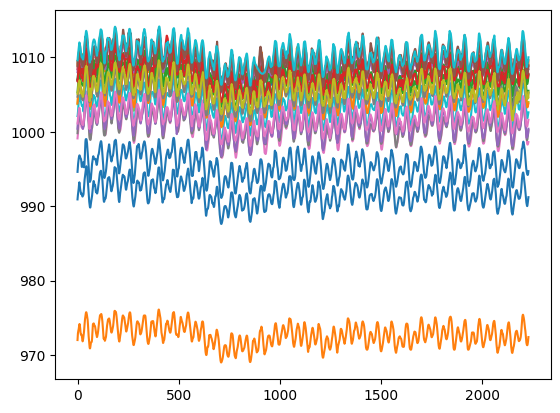

In [64]:
P = wsdata_interpo["presion"].values.reshape(wsdata_interpo["codigo_estacion"].nunique() , -1)
for idx in range(len(P)):
    plt.plot(P[idx,:])
# plt.plot([775]*P[idx,:].shape[0])
plt.show()

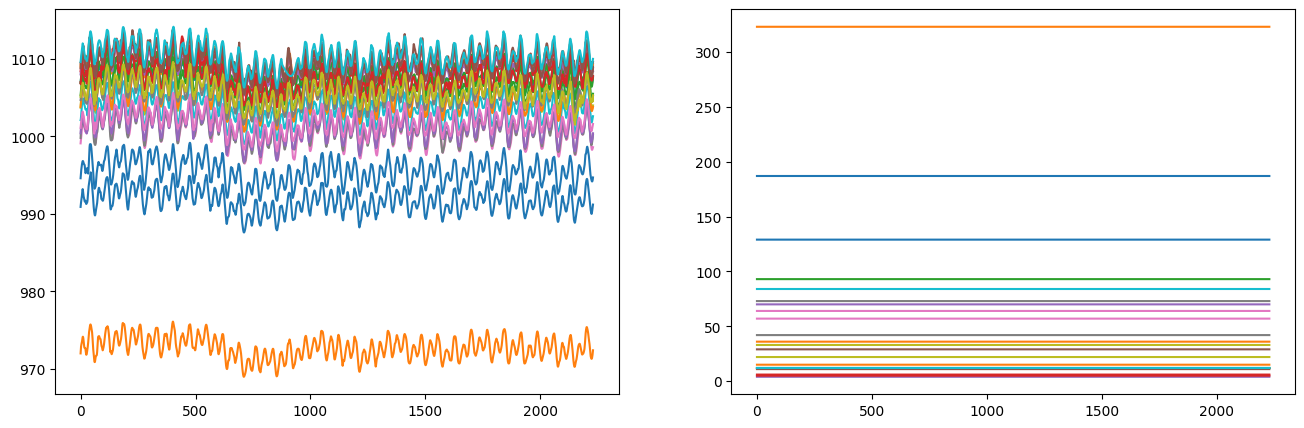

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

A = wsdata_interpo["presion"].values.reshape(wsdata_interpo["codigo_estacion"].nunique() , -1)
B = wsdata_interpo["altura"].values.reshape(wsdata_interpo["codigo_estacion"].nunique() , -1)

for idx in range(len(P)):
    ax[0].plot(A[idx,:])
    ax[1].plot(B[idx,:])
    
    
plt.show()

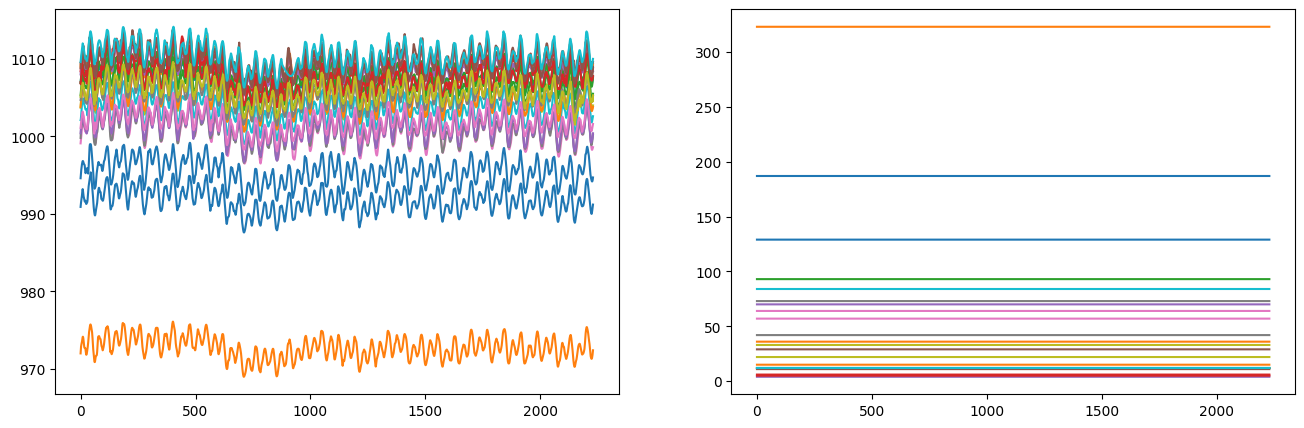

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

A = wsdata_interpo["presion"].values.reshape(wsdata_interpo["codigo_estacion"].nunique() , -1)
B = wsdata_interpo["altura"].values.reshape(wsdata_interpo["codigo_estacion"].nunique() , -1)

for idx in range(len(A)):
    ax[0].plot(A[idx,:])
    ax[1].plot(B[idx,:])
    
    
plt.show()

In [67]:
wsdata_interpo["segundos"].values.reshape(wsdata_interpo["codigo_estacion"].nunique() , -1)

array([[0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       ...,
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06]], shape=(22, 2230))

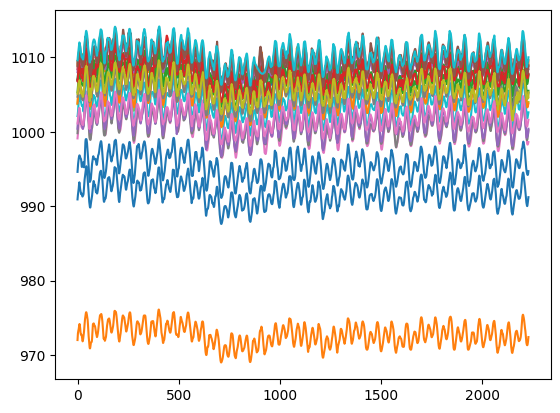

In [68]:
P = wsdata_interpo["presion"].values.reshape(wsdata_interpo["codigo_estacion"].nunique() , -1)
for idx in range(len(P)):
    plt.plot(P[idx,:])
# plt.plot([775]*P[idx,:].shape[0])
plt.show()

In [69]:
wsdata_interpo["segundos"].values.reshape(wsdata_interpo["codigo_estacion"].nunique() , -1)

array([[0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       ...,
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06],
       [0.0000e+00, 1.2000e+03, 2.4000e+03, ..., 2.6724e+06, 2.6736e+06,
        2.6748e+06]], shape=(22, 2230))

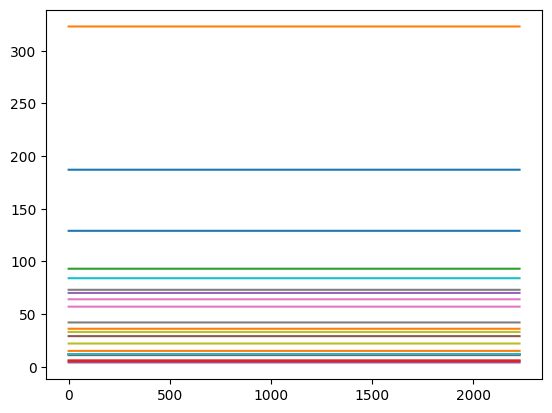

In [70]:
P = wsdata_interpo["altura"].values.reshape(wsdata_interpo["codigo_estacion"].nunique() , -1)
for idx in range(len(P)):
    plt.plot(P[idx,:])
# plt.plot([775]*P[idx,:].shape[0])
plt.show()

# Completar fechas con NaN

In [71]:
# estaciones_registradas = wsdata["codigo_estacion"].unique()
# estaciones = list()
# latitudes = list()
# longitudes = list()
# alturas = list()

# for estacion in estaciones_registradas:
#     estaciones += [estacion]*len(rango_tiempo)
#     latitudes += [wsdata.loc[wsdata["codigo_estacion"] == estacion, "latitud"].unique()[0]]*len(rango_tiempo)
#     longitudes += [wsdata.loc[wsdata["codigo_estacion"] == estacion, "longitud"].unique()[0]]*len(rango_tiempo)
#     alturas += [wsdata.loc[wsdata["codigo_estacion"] == estacion, "altura"].unique()[0]]*len(rango_tiempo)
    
#     ...

# fechas = rango_tiempo * len(estaciones_registradas)

In [72]:
# base_estacion_fechas = pd.DataFrame({"codigo_estacion":estaciones, "fecha_observacion":fechas, "latitud":latitudes, "longitud":longitudes, "altura":alturas})
# wsdata_full = pd.merge(left=base_estacion_fechas, right=wsdata, on=["codigo_estacion", "fecha_observacion", "latitud", "longitud", "altura"], how="left")

In [73]:
# wsdata_full.head()

In [74]:
# wsdata_full = wsdata_full.sort_values(["codigo_estacion", "fecha_observacion"]).reset_index(drop=True)

In [75]:
# wsdata_full["vel_u"] = wsdata_full.apply(lambda df: df["velocidad"] * np.sin(np.pi*(df["direccion"]/180)), axis=1)
# wsdata_full["vel_v"] = wsdata_full.apply(lambda df: df["velocidad"] * np.cos(np.pi*(df["direccion"]/180)), axis=1)

In [76]:
# wsdata_full["segundos"] = (wsdata_full["fecha_observacion"] - fecha_inicio) / np.timedelta64(1, 's')

In [77]:
# wsdata_full = wsdata_full[[
#     'codigo_estacion',
#     'latitud',
#     'longitud',
#     'altura',
#     'segundos',
#     'presion',
#     'vel_u',
#     'vel_v',
#     'temperatura',
# ]].copy()

In [78]:
# wsdata_full.sample(5)

In [79]:
# path_save_wsdata = Path().cwd().parent / "data" / "raw" / "em_bgta_251201_251231.parquet"
# path_save_wsdata_full = Path().cwd().parent / "data" / "raw" / "em_bgta_251201_251231_full.parquet"
# wsdata.to_parquet(path_save_wsdata, engine="fastparquet", index=False)
# wsdata_full.to_parquet(path_save_wsdata_full, engine="fastparquet", index=False)

# Exportar

In [80]:
wsdata.tail()

,codigo_estacion,latitud,longitud,altura,segundos,presion,vel_u,vel_v,temperatura
28722,2906500077,10.772,-74.019,1062.0,2660400.0,895.7,0.135887,-1.292878,26.2
28723,2906500077,10.772,-74.019,1062.0,2664000.0,895.2,-0.541634,-0.718772,24.8
28724,2906500077,10.772,-74.019,1062.0,2667600.0,895.0,1.540723,0.718451,22.1
28725,2906500077,10.772,-74.019,1062.0,2671200.0,895.3,1.067325,0.266114,22.8
28726,2906500077,10.772,-74.019,1062.0,2674800.0,895.5,1.603812,0.817183,21.6


In [81]:
wsdata_filtrada.tail()

,codigo_estacion,latitud,longitud,altura,segundos,presion,vel_u,vel_v,temperatura
27268,2901500072,9.673,-75.237,323.0,2660400.0,972.1,-1.096255,-0.488084,37.5
27269,2901500072,9.673,-75.237,323.0,2664000.0,971.5,-2.265769,-1.056546,37.5
27270,2901500072,9.673,-75.237,323.0,2667600.0,971.3,-2.035315,-1.271806,33.9
27271,2901500072,9.673,-75.237,323.0,2671200.0,971.6,-1.851303,-0.427407,33.2
27272,2901500072,9.673,-75.237,323.0,2674800.0,972.4,-0.906308,-0.422618,32.9


In [82]:
wsdata_interpo.tail()

,codigo_estacion,segundos,presion,vel_u,vel_v,temperatura,latitud,longitud,altura
49055,2901500072,2670000.0,971.440839,-1.902542,-0.743100,33.111533,9.673,-75.237,323.0
49056,2901500072,2671200.0,971.600000,-1.851303,-0.427407,33.200000,9.673,-75.237,323.0
49057,2901500072,2672400.0,971.814717,-1.715511,-0.205004,33.332912,9.673,-75.237,323.0
49058,2901500072,2673600.0,972.082285,-1.424176,-0.171528,33.302251,9.673,-75.237,323.0
49059,2901500072,2674800.0,972.400000,-0.906308,-0.422618,32.900000,9.673,-75.237,323.0


In [84]:
wsdata_interpo["codigo_estacion"].nunique()

22

In [85]:
path_save_wsdata = Path().cwd().parent / "data" / "raw" / "em_caribe_251201_251231.parquet"
wsdata.to_parquet(path_save_wsdata, engine="fastparquet", index=False)


In [86]:
path_save_wsdata_filtrada = Path().cwd().parent / "data" / "raw" / "em_caribe_251201_251231_22ws.parquet"
wsdata_filtrada.to_parquet(path_save_wsdata_filtrada, engine="fastparquet", index=False)


In [87]:
path_save_wsdata_interpo = Path().cwd().parent / "data" / "raw" / "em_caribe_251201_251231_22ws_interpo.parquet"
wsdata_interpo.to_parquet(path_save_wsdata_interpo, engine="fastparquet", index=False)
